На старте мы получаем две таблицы, в одной из которых содержатся транзакции, а во второй клиенты. Мы хотим спроектировать такую систему БД, которая была бы нормализованна до 3НФ. Пример подобного решения:

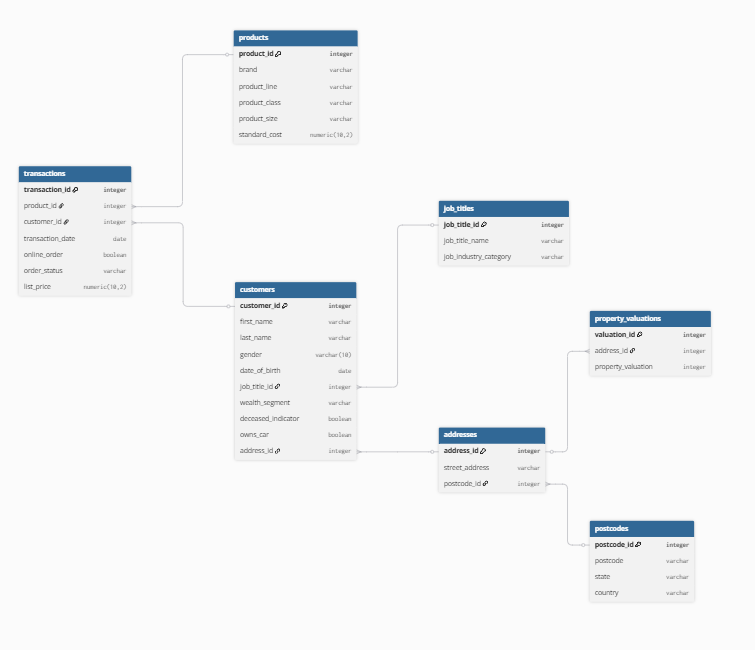

### Почему именно так? Потому что в изначальных таблицах были транзитивные зависимости, котрорые мы убрали, введя отдельные таблицы и id:

1. В таблице с транзакциями описание продукта (бренд, продуктовая линейка, класс, размер, стандартная стоимость) зависит от product_id. Мы выделяем отдельную таблицу с описанием продукта.
2. В таблице с клиентами отрасль промышленности (job_industry_category) зависит от должности (job_title), а не от customer_id. Мы выделяем отдельную таблицу job_titles.
3.В таблице с адресами штат (state) и страна (country) зависят от почтового индекса (postcode), а не от address_id. Мы выделяем отдельную таблицу postcodes.
4. В таблице с адресами оценка недвижимости (property_valuation) зависит от адреса, а не является независимым атрибутом. Мы выделяем отдельную таблицу property_valuations.

Таким образом, в каждой таблице неключевые атрибуты зависят только от первичного ключа.

### Итого, в редакторе написаны следующие зависимости:<br>
Ref: transactions.customer_id > customers.customer_id<br>
Ref: transactions.product_id > products.product_id<br>
Ref: customers.address_id > addresses.address_id<br>
Ref: customers.job_title_id > job_titles.job_title_id<br>
Ref: addresses.postcode_id > postcodes.postcode_id<br>
Ref: property_valuations.address_id > addresses.address_id<br>

# Скрипт, которым создаются таблички:<br>
CREATE TABLE postcodes ( <br>
    postcode_id SERIAL PRIMARY KEY, <br>
    postcode VARCHAR(10) NOT NULL, <br>
    state VARCHAR(50) NOT NULL, <br>
    country VARCHAR(50) NOT NULL <br>
);

CREATE TABLE job_titles (<br>
    job_title_id SERIAL PRIMARY KEY,<br>
    job_title_name VARCHAR(100) NOT NULL,<br>
    job_industry_category VARCHAR(100)<br>
);

CREATE TABLE products (<br>
    product_id INTEGER PRIMARY KEY,<br>
    brand VARCHAR(50) NOT NULL,<br>
    product_line VARCHAR(50) NOT NULL,<br>
    product_class VARCHAR(50) NOT NULL,<br>
    product_size VARCHAR(50) NOT NULL,<br>
    standard_cost NUMERIC(10,2)<br>
);

CREATE TABLE addresses (<br>
    address_id SERIAL PRIMARY KEY,<br>
    street_address VARCHAR(200) NOT NULL,<br>
    postcode_id INTEGER REFERENCES postcodes(postcode_id)<br>
);

CREATE TABLE property_valuations (<br>
    valuation_id SERIAL PRIMARY KEY,<br>
    address_id INTEGER REFERENCES addresses(address_id),<br>
    property_valuation INTEGER NOT NULL<br>
);

CREATE TABLE customers (<br>
    customer_id INTEGER PRIMARY KEY,<br>
    first_name VARCHAR(100),<br>
    last_name VARCHAR(100),<br>
    gender VARCHAR(10),<br>
    date_of_birth DATE,<br>
    job_title_id INTEGER REFERENCES job_titles(job_title_id),<br>
    wealth_segment VARCHAR(50),<br>
    deceased_indicator BOOLEAN,<br>
    owns_car BOOLEAN,<br>
    address_id INTEGER REFERENCES addresses(address_id)<br>
);

CREATE TABLE transactions (<br>
    transaction_id INTEGER PRIMARY KEY,<br>
    product_id INTEGER REFERENCES products(product_id),<br>
    customer_id INTEGER REFERENCES customers(customer_id),<br>
    transaction_date DATE NOT NULL,<br>
    online_order BOOLEAN,<br>
    order_status VARCHAR(20) NOT NULL,<br>
    list_price NUMERIC(10,2) NOT NULL<br>
);

Хорошей практикой так же является загрузка в БД raw-данных. Для этого мы создадим сырые таблички, из которых потом будем заливать данные в нормализованные таблицы.

# Создание raw-таблиц:
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY, <br>
    first_name VARCHAR(100),<br>
    last_name VARCHAR(100),<br>
    gender VARCHAR(10),<br>
    date_of_birth DATE,<br>
    job_title_id INTEGER REFERENCES job_titles(job_title_id),<br>
    wealth_segment VARCHAR(50),<br>
    deceased_indicator BOOLEAN,<br>
    owns_car BOOLEAN,<br>
    address_id INTEGER REFERENCES addresses(address_id)<br>
);

CREATE TABLE transactions (<br>
    transaction_id INTEGER PRIMARY KEY,<br>
    product_id INTEGER REFERENCES products(product_id),<br>
    customer_id INTEGER REFERENCES customers(customer_id),<br>
    transaction_date DATE NOT NULL,<br>
    online_order BOOLEAN,<br>
    order_status VARCHAR(20) NOT NULL,<br>
    list_price NUMERIC(10,2) NOT NULL<br>
);


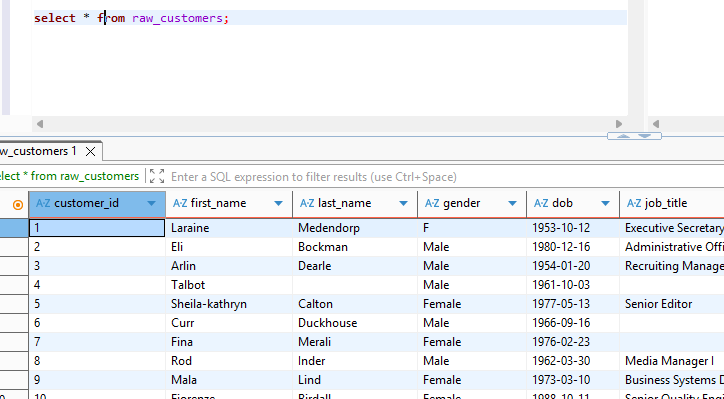

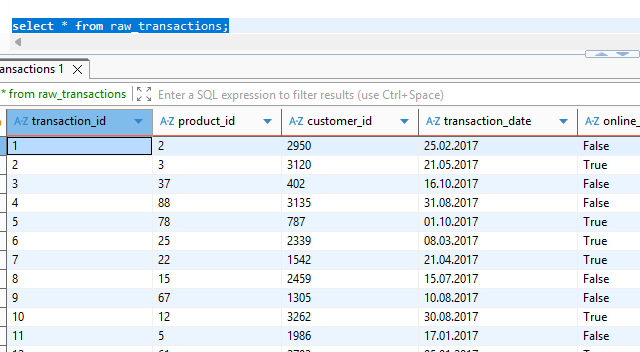

ВИдим, что не все id уникальные. Учитываем это при вставке в основную БД. Поьзуемся разрешением не грузить всю таблицу, чтобы избегать необходимости решать проблемы кривых данных.

INSERT INTO postcodes (postcode, state, country) <br>
SELECT DISTINCT postcode, state, country <br>
FROM raw_customers <br>
WHERE postcode IS NOT NULL;<br>

select * from postcodes;

INSERT INTO job_titles (job_title_name, job_industry_category)<br>
SELECT DISTINCT <br>
    NULLIF(TRIM(job_title), '') as job_title_name,<br>
    NULLIF(TRIM(job_industry_category), '') as job_industry_category<br>
FROM raw_customers <br>
WHERE job_title IS NOT NULL AND TRIM(job_title) != '';<br>

select * from job_titles;

INSERT INTO addresses (street_address, postcode_id)<br>
SELECT DISTINCT <br>
    rc.address,<br>
    p.postcode_id<br>
FROM raw_customers rc<br>
JOIN postcodes p ON rc.postcode = p.postcode AND rc.state = p.state;<br>

select * from addresses;

INSERT INTO property_valuations (address_id, property_valuation)<br>
SELECT <br>
    a.address_id,<br>
    rc.property_valuation<br>
FROM raw_customers rc<br>
JOIN addresses a ON rc.address = a.street_address;<br>

select * from property_valuations;


--customers
INSERT INTO customers (customer_id, first_name, last_name, gender, date_of_birth, job_title_id, wealth_segment, deceased_indicator, owns_car, address_id)<br>
SELECT <br>
    rc.customer_id::INTEGER,<br>
    rc.first_name,<br>
    rc.last_name,<br>
    rc.gender,<br>
    TO_DATE(rc.dob, 'YYYY-MM-DD'),<br>
    jt.job_title_id,<br>
    rc.wealth_segment,<br>
    rc.deceased_indicator,<br>
    rc.owns_car,<br>
    a.address_id<br>
FROM raw_customers rc<br>
LEFT JOIN job_titles jt ON NULLIF(TRIM(rc.job_title), '') = jt.job_title_name
JOIN addresses a ON rc.address = a.street_address<br>
ON CONFLICT (customer_id) DO NOTHING; --немного топорный метод избежать багов

select * from customers;

INSERT INTO products (product_id, brand, product_line, product_class, product_size, standard_cost)<br>
SELECT DISTINCT <br>
    rt.product_id::INTEGER,<br>
    rt.brand,<br>
    rt.product_line,<br>
    rt.product_class,<br>
    rt.product_size,<br>
    CASE <br>
        WHEN standard_cost != '' AND standard_cost IS NOT NULL <br>
             AND standard_cost ~ '^[\d,]+\.?\d*$' <br>
        THEN CAST(REPLACE(standard_cost, ',', '') AS NUMERIC(10,2))<br>
        ELSE null END as standard_cost<br>
FROM raw_transactions rt <br>
WHERE rt.product_id IS NOT null<br>
ON CONFLICT (product_id) DO NOTHING;<br>

select * from products;


INSERT INTO transactions (transaction_id, product_id, customer_id, transaction_date, online_order, order_status, list_price)<br>
SELECT <br>
    transaction_id::INTEGER,<br>
    product_id::INTEGER,<br>
    customer_id::INTEGER,<br>
    TO_DATE(transaction_date, 'DD.MM.YYYY'), <br>
    online_order ,<br>
    order_status,<br>
    CAST(REPLACE(list_price, ',', '') AS NUMERIC(10,2))<br>
FROM (<br>
    SELECT <br>
        transaction_id,<br>
        product_id,<br>
        customer_id,<br>
        transaction_date,<br>
        online_order,<br>
        order_status,<br>
        list_price<br>
    FROM raw_transactions <br>
    limit 100 --потому что в ТЗ написано, что можно сократить выборку загрузки и я этим пользуюсь для сокращения времени выполнения ДЗ :)
);

select * from transactions;